In [1]:
# 导入必要的库
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 设置图表样式
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("库导入完成！")


库导入完成！


In [2]:
# 初始化Spark Session
spark = SparkSession.builder \
    .appName("TweetAnalysis_Classification") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Available cores: {spark.sparkContext.defaultParallelism}")


Spark Version: 3.5.0
Available cores: 20


In [3]:
# 加载主题分析和情感分析的数据
print("=== 数据加载 ===")

# 尝试加载主题分析结果
topic_data_path = "/home/jovyan/work/data/processed/topic_analyzed_comments.parquet"

try:
    df_topic = spark.read.parquet(topic_data_path)
    df_topic.cache()
    record_count = df_topic.count()
    print(f"✅ 主题分析数据加载完成，共 {record_count:,} 条记录")
    
    print("\n数据结构:")
    df_topic.printSchema()
    
    # 检查必要的列
    required_cols = ['sentiment_label', 'cleaned_body', 'dominant_topic']
    missing_cols = [col for col in required_cols if col not in df_topic.columns]
    
    if missing_cols:
        print(f"❌ 缺少必要列: {missing_cols}")
        print("尝试加载其他数据源...")
        
        # 备选方案：加载情感分析数据
        sentiment_data_path = "/home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet"
        df_sentiment = spark.read.parquet(sentiment_data_path)
        
        # 需要重新进行情感分类
        def classify_sentiment(score):
            if score is None:
                return "未知"
            elif score > 0.1:
                return "积极"
            elif score < -0.1:
                return "消极"
            else:
                return "中性"
        
        classify_sentiment_udf = F.udf(classify_sentiment, StringType())
        
        # 找到情感分数列
        sentiment_col = None
        for col in ['compound_score', 'vader_compound', 'sentiment']:
            if col in df_sentiment.columns:
                sentiment_col = col
                break
        
        if sentiment_col:
            df_topic = df_sentiment.withColumn(
                "sentiment_label",
                classify_sentiment_udf(F.col(sentiment_col))
            )
            df_topic = df_topic.withColumn("dominant_topic", F.lit(0))  # 临时主题
            record_count = df_topic.count()
            print(f"✅ 使用情感分析数据，共 {record_count:,} 条记录")
        else:
            raise Exception("未找到情感分数列")
    else:
        print("✅ 所有必要列都存在")
        
except Exception as e:
    print(f"❌ 数据加载失败: {e}")
    print("使用清洗后的数据作为备选方案...")
    
    # 最后备选：使用清洗后的数据
    cleaned_data_path = "/home/jovyan/work/data/processed/cleaned_comments.parquet"
    df_base = spark.read.parquet(cleaned_data_path)
    
    # 使用原始sentiment列
    def classify_sentiment(score):
        if score is None:
            return "未知"
        elif score > 0.1:
            return "积极"
        elif score < -0.1:
            return "消极"
        else:
            return "中性"
    
    classify_sentiment_udf = F.udf(classify_sentiment, StringType())
    
    df_topic = df_base.withColumn(
        "sentiment_label",
        classify_sentiment_udf(F.col("sentiment"))
    ).withColumn("dominant_topic", F.lit(0))  # 临时主题
    
    record_count = df_topic.count()
    print(f"✅ 使用清洗后数据，共 {record_count:,} 条记录")


=== 数据加载 ===
❌ 数据加载失败: [PATH_NOT_FOUND] Path does not exist: file:/home/jovyan/work/data/processed/topic_analyzed_comments.parquet.
使用清洗后的数据作为备选方案...
✅ 使用清洗后数据，共 459,171 条记录


In [4]:
# 数据预处理和特征工程
print("=== 数据预处理和特征工程 ===")

# 1. 检查情感标签分布
print("1. 情感标签分布:")
sentiment_dist = df_topic.groupBy("sentiment_label").count().orderBy(F.desc("count"))
sentiment_dist.show()

# 转换为pandas查看详细比例
sentiment_dist_pd = sentiment_dist.toPandas()
total_count = sentiment_dist_pd['count'].sum()
sentiment_dist_pd['percentage'] = (sentiment_dist_pd['count'] / total_count * 100).round(2)

print("详细分布:")
for _, row in sentiment_dist_pd.iterrows():
    label = row['sentiment_label']
    count = int(row['count'])
    pct = row['percentage']
    print(f"  {label}: {count:,} ({pct}%)")

# 2. 过滤掉"未知"标签的数据（如果存在）
df_filtered = df_topic.filter(F.col("sentiment_label") != "未知")
filtered_count = df_filtered.count()
print(f"\n过滤后数据量: {filtered_count:,} 条记录")

# 3. 检查是否有分词结果，如果没有则重新分词
if 'tokens_cleaned' not in df_filtered.columns:
    print("3. 重新进行文本分词...")
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    
    # 分词
    tokenizer = Tokenizer(inputCol="cleaned_body", outputCol="tokens_raw")
    df_tokens = tokenizer.transform(df_filtered)
    
    # 去停用词
    remover = StopWordsRemover(inputCol="tokens_raw", outputCol="tokens_cleaned")
    df_filtered = remover.transform(df_tokens)
    print("   分词完成")
else:
    print("3. ✅ 已有分词结果")

print(f"\n最终用于建模的数据: {df_filtered.count():,} 条记录")


=== 数据预处理和特征工程 ===
1. 情感标签分布:
+---------------+------+
|sentiment_label| count|
+---------------+------+
|           消极|205850|
|           积极|201235|
|           中性| 47179|
|           未知|  4907|
+---------------+------+

详细分布:
  消极: 205,850 (44.83%)
  积极: 201,235 (43.83%)
  中性: 47,179 (10.27%)
  未知: 4,907 (1.07%)

过滤后数据量: 454,264 条记录
3. ✅ 已有分词结果

最终用于建模的数据: 454,264 条记录


In [5]:
# 构建特征向量
print("=== 构建特征向量 ===")

from pyspark.ml.feature import CountVectorizer, IDF

# 1. 文本特征：TF-IDF向量化
print("1. 构建TF-IDF特征...")

# CountVectorizer
count_vectorizer = CountVectorizer(
    inputCol="tokens_cleaned", 
    outputCol="raw_features",
    vocabSize=3000,  # 减少特征维度提高训练速度
    minDF=3.0        # 最小文档频率
)

count_model = count_vectorizer.fit(df_filtered)
df_vectorized = count_model.transform(df_filtered)

# TF-IDF
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_vectorized)
df_tfidf = idf_model.transform(df_vectorized)

print(f"   TF-IDF词汇表大小: {len(count_model.vocabulary)}")

# 2. 主题特征处理（简化处理避免OneHotEncoder问题）
if 'dominant_topic' in df_tfidf.columns:
    print("2. 检查主题特征...")
    # 检查主题值的唯一性
    unique_topics = df_tfidf.select("dominant_topic").distinct().count()
    print(f"   发现 {unique_topics} 个不同的主题值")
    
    if unique_topics > 1:
        print("   添加主题特征...")
        from pyspark.ml.feature import OneHotEncoder
        
        # 先转换为数值索引
        indexer = StringIndexer(inputCol="dominant_topic", outputCol="topic_index")
        indexer_model = indexer.fit(df_tfidf)
        df_indexed = indexer_model.transform(df_tfidf)
        
        # One-hot编码
        encoder = OneHotEncoder(inputCol="topic_index", outputCol="topic_features")
        df_encoded = encoder.fit(df_indexed).transform(df_indexed)
        
        # 合并TF-IDF和主题特征
        assembler = VectorAssembler(
            inputCols=["tfidf_features", "topic_features"],
            outputCol="features"
        )
        df_features = assembler.transform(df_encoded)
        print("   ✅ TF-IDF + 主题特征合并完成")
    else:
        print("   ⚠️ 主题值太少，跳过主题特征，仅使用TF-IDF特征")
        df_features = df_tfidf.withColumnRenamed("tfidf_features", "features")
else:
    print("2. 仅使用TF-IDF特征...")
    df_features = df_tfidf.withColumnRenamed("tfidf_features", "features")

print(f"最终特征数据: {df_features.count():,} 条记录")


=== 构建特征向量 ===
1. 构建TF-IDF特征...
   TF-IDF词汇表大小: 3000
2. 检查主题特征...
   发现 1 个不同的主题值
   ⚠️ 主题值太少，跳过主题特征，仅使用TF-IDF特征
最终特征数据: 454,264 条记录


In [6]:
# 准备训练数据和标签编码
print("=== 准备训练数据 ===")

# 检查df_features是否存在，如果不存在则使用df_tfidf
if 'df_features' not in locals():
    print("⚠️ df_features未定义，使用df_tfidf作为特征数据")
    df_features = df_tfidf.withColumnRenamed("tfidf_features", "features")

# 1. 将情感标签转换为数值索引
label_indexer = StringIndexer(inputCol="sentiment_label", outputCol="label")
indexer_model = label_indexer.fit(df_features)
df_labeled = indexer_model.transform(df_features)

# 获取标签映射
labels = indexer_model.labels
print(f"标签映射: {dict(enumerate(labels))}")

# 2. 划分训练集和测试集
print("2. 划分训练集和测试集...")
train_data, test_data = df_labeled.randomSplit([0.8, 0.2], seed=42)

train_count = train_data.count()
test_count = test_data.count()

print(f"训练集: {train_count:,} 条记录")
print(f"测试集: {test_count:,} 条记录")

# 缓存数据提高后续训练速度
train_data.cache()
test_data.cache()

# 3. 检查训练集中的标签分布
print("\n3. 训练集标签分布:")
train_label_dist = train_data.groupBy("sentiment_label").count().orderBy(F.desc("count"))
train_label_dist.show()

print("测试集标签分布:")
test_label_dist = test_data.groupBy("sentiment_label").count().orderBy(F.desc("count"))
test_label_dist.show()


=== 准备训练数据 ===
标签映射: {0: '消极', 1: '积极', 2: '中性'}
2. 划分训练集和测试集...
训练集: 363,582 条记录
测试集: 90,682 条记录

3. 训练集标签分布:
+---------------+------+
|sentiment_label| count|
+---------------+------+
|           消极|164597|
|           积极|161185|
|           中性| 37800|
+---------------+------+

测试集标签分布:
+---------------+-----+
|sentiment_label|count|
+---------------+-----+
|           消极|41253|
|           积极|40050|
|           中性| 9379|
+---------------+-----+



In [7]:
# 训练Naive Bayes模型
print("=== 训练Naive Bayes模型 ===")

# 检查必要变量是否存在
if 'train_data' not in locals() or 'test_data' not in locals():
    print("❌ 训练/测试数据未准备，请先运行上一个cell")
else:
    # 1. 创建Naive Bayes分类器
    nb = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="nb_prediction")

    print("1. 开始训练Naive Bayes模型...")
    nb_model = nb.fit(train_data)
    print("   ✅ Naive Bayes训练完成")

    # 2. 在测试集上进行预测
    print("2. 在测试集上预测...")
    nb_predictions = nb_model.transform(test_data)

    # 3. 评估Naive Bayes模型
    print("3. 评估Naive Bayes模型:")

    # 准确率
    evaluator_accuracy = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="nb_prediction", metricName="accuracy"
    )
    nb_accuracy = evaluator_accuracy.evaluate(nb_predictions)

    # F1分数
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="nb_prediction", metricName="f1"
    )
    nb_f1 = evaluator_f1.evaluate(nb_predictions)

    # 加权精确率
    evaluator_precision = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="nb_prediction", metricName="weightedPrecision"
    )
    nb_precision = evaluator_precision.evaluate(nb_predictions)

    # 加权召回率
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="nb_prediction", metricName="weightedRecall"
    )
    nb_recall = evaluator_recall.evaluate(nb_predictions)

    print(f"   准确率: {nb_accuracy:.4f}")
    print(f"   F1分数: {nb_f1:.4f}")
    print(f"   加权精确率: {nb_precision:.4f}")
    print(f"   加权召回率: {nb_recall:.4f}")

    # 保存Naive Bayes结果
    nb_results = {
        'model': 'Naive Bayes',
        'accuracy': nb_accuracy,
        'f1': nb_f1,
        'precision': nb_precision,
        'recall': nb_recall
    }


=== 训练Naive Bayes模型 ===
1. 开始训练Naive Bayes模型...
   ✅ Naive Bayes训练完成
2. 在测试集上预测...
3. 评估Naive Bayes模型:
   准确率: 0.5564
   F1分数: 0.5858
   加权精确率: 0.6466
   加权召回率: 0.5564


In [8]:
# 训练Random Forest模型
print("=== 训练Random Forest模型 ===")

# 1. 创建Random Forest分类器
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="rf_prediction",
    numTrees=50,        # 树的数量，可以根据需要调整
    maxDepth=10,        # 最大深度
    seed=42
)

print("1. 开始训练Random Forest模型...")
rf_model = rf.fit(train_data)
print("   ✅ Random Forest训练完成")

# 2. 在测试集上进行预测
print("2. 在测试集上预测...")
rf_predictions = rf_model.transform(test_data)

# 3. 评估Random Forest模型
print("3. 评估Random Forest模型:")

# 准确率
rf_accuracy = evaluator_accuracy.setParams(predictionCol="rf_prediction").evaluate(rf_predictions)

# F1分数
rf_f1 = evaluator_f1.setParams(predictionCol="rf_prediction").evaluate(rf_predictions)

# 加权精确率
rf_precision = evaluator_precision.setParams(predictionCol="rf_prediction").evaluate(rf_predictions)

# 加权召回率
rf_recall = evaluator_recall.setParams(predictionCol="rf_prediction").evaluate(rf_predictions)

print(f"   准确率: {rf_accuracy:.4f}")
print(f"   F1分数: {rf_f1:.4f}")
print(f"   加权精确率: {rf_precision:.4f}")
print(f"   加权召回率: {rf_recall:.4f}")

# 保存Random Forest结果
rf_results = {
    'model': 'Random Forest',
    'accuracy': rf_accuracy,
    'f1': rf_f1,
    'precision': rf_precision,
    'recall': rf_recall
}

# 4. 特征重要性分析
print("\n4. 特征重要性分析:")
feature_importances = rf_model.featureImportances
print(f"特征重要性向量长度: {len(feature_importances)}")

# 获取最重要的特征（如果是文本特征）
if len(feature_importances) > 0:
    # 转换为pandas进行分析
    importance_array = feature_importances.toArray()
    
    # 如果特征主要是词汇特征，显示最重要的词汇
    vocab_size = len(count_model.vocabulary)
    if vocab_size <= len(importance_array):
        word_importance = [(count_model.vocabulary[i], importance_array[i]) 
                          for i in range(min(vocab_size, len(importance_array)))]
        word_importance.sort(key=lambda x: x[1], reverse=True)
        
        print("   最重要的10个词汇特征:")
        for word, importance in word_importance[:10]:
            print(f"     {word}: {importance:.6f}")
    
    print(f"   特征重要性总和: {sum(importance_array):.6f}")


=== 训练Random Forest模型 ===
1. 开始训练Random Forest模型...
   ✅ Random Forest训练完成
2. 在测试集上预测...
3. 评估Random Forest模型:
   准确率: 0.6079
   F1分数: 0.5732
   加权精确率: 0.5596
   加权召回率: 0.6079

4. 特征重要性分析:
特征重要性向量长度: 3000
   最重要的10个词汇特征:
     like: 0.048235
     best: 0.038138
     good: 0.036014
     fuck: 0.035844
     better: 0.029335
     energy: 0.028918
     pretty: 0.023837
     bad: 0.021586
     great: 0.020438
     kill: 0.018842
   特征重要性总和: 1.000000


=== 模型比较和评估报告 ===
1. 模型性能比较:
           model  accuracy      f1  precision  recall
0    Naive Bayes    0.5564  0.5858     0.6466  0.5564
1  Random Forest    0.6079  0.5732     0.5596  0.6079


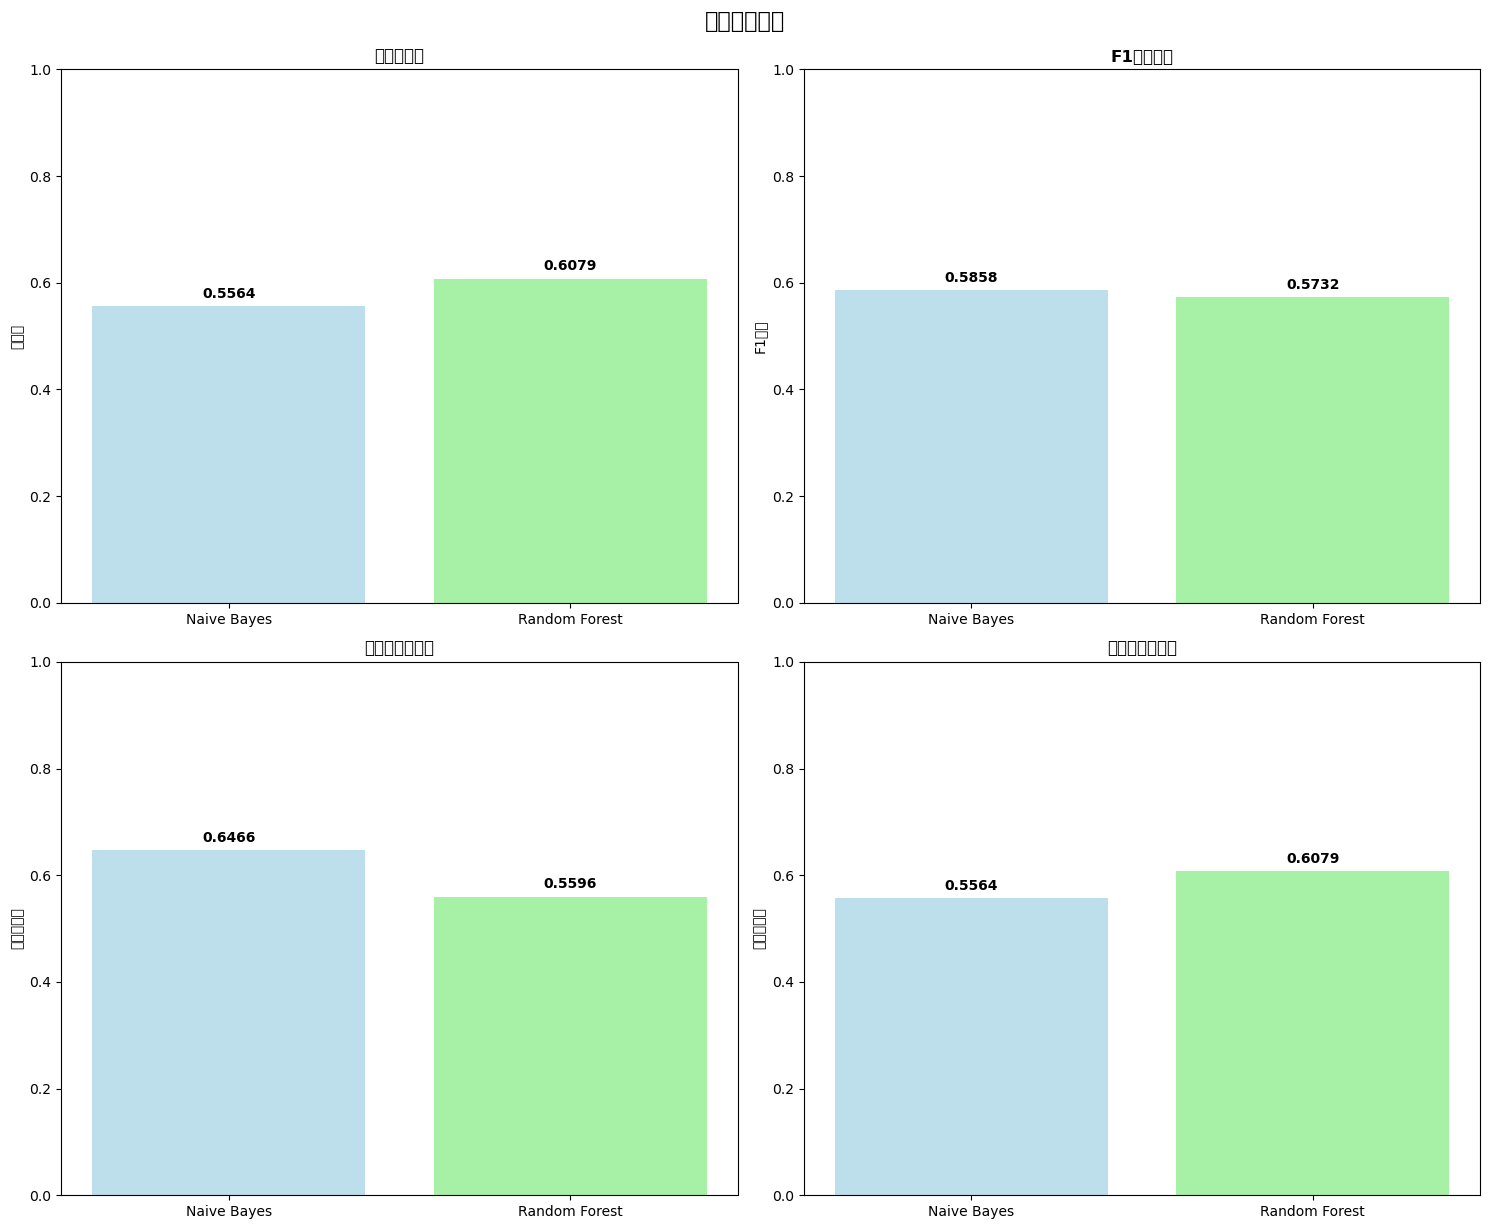


3. 最佳模型: Naive Bayes (F1分数: 0.5858)


In [9]:
# 模型比较和评估报告
print("=== 模型比较和评估报告 ===")

# 1. 模型性能比较
results_comparison = pd.DataFrame([nb_results, rf_results])
print("1. 模型性能比较:")
print(results_comparison.round(4))

# 2. 可视化模型比较
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['accuracy', 'f1', 'precision', 'recall']
metric_names = ['准确率', 'F1分数', '加权精确率', '加权召回率']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    
    values = [nb_results[metric], rf_results[metric]]
    models = ['Naive Bayes', 'Random Forest']
    colors = ['lightblue', 'lightgreen']
    
    bars = ax.bar(models, values, color=colors, alpha=0.8)
    ax.set_title(f'{name}比较', fontweight='bold')
    ax.set_ylabel(name)
    ax.set_ylim(0, 1)
    
    # 在柱状图上添加数值标签
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('模型性能比较', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# 3. 确定最佳模型
best_model_name = 'Naive Bayes' if nb_f1 > rf_f1 else 'Random Forest'
best_predictions = nb_predictions if nb_f1 > rf_f1 else rf_predictions
best_pred_col = 'nb_prediction' if nb_f1 > rf_f1 else 'rf_prediction'

print(f"\n3. 最佳模型: {best_model_name} (F1分数: {max(nb_f1, rf_f1):.4f})")


=== 详细分类报告 ===
为最佳模型 (Naive Bayes) 生成详细报告:

1. 分类报告:
              precision    recall  f1-score   support

          中性       0.19      0.51      0.28      9379
          消极       0.68      0.60      0.64     41253
          积极       0.72      0.52      0.60     40050

    accuracy                           0.56     90682
   macro avg       0.53      0.54      0.51     90682
weighted avg       0.65      0.56      0.59     90682

2. 混淆矩阵:
[[24954  6232 10067]
 [ 8981 20743 10326]
 [ 2728  1892  4759]]


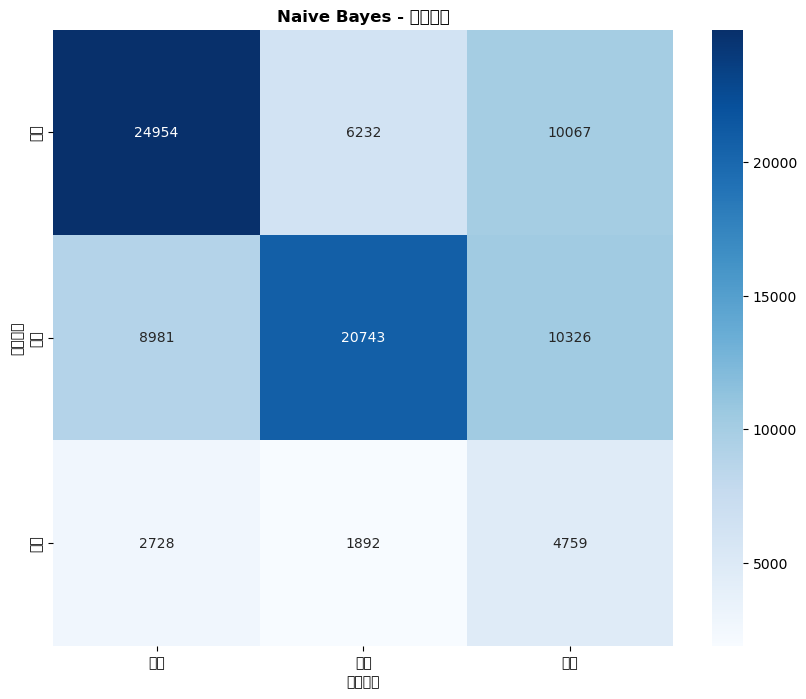


3. 各类别性能分析:
  消极:
    精确率: 0.6806
    召回率: 0.6049
    F1分数: 0.6405
    支持样本数: 41253
  积极:
    精确率: 0.7186
    召回率: 0.5179
    F1分数: 0.6020
    支持样本数: 40050
  中性:
    精确率: 0.1892
    召回率: 0.5074
    F1分数: 0.2756
    支持样本数: 9379


In [10]:
# 详细的分类报告和混淆矩阵
print("=== 详细分类报告 ===")

# 1. 生成混淆矩阵数据
def get_confusion_matrix_data(predictions, prediction_col):
    """生成混淆矩阵数据"""
    # 收集预测结果
    results = predictions.select("label", prediction_col).collect()
    
    y_true = [row["label"] for row in results]
    y_pred = [row[prediction_col] for row in results]
    
    return y_true, y_pred

# 2. 为最佳模型生成详细报告
print(f"为最佳模型 ({best_model_name}) 生成详细报告:")

y_true, y_pred = get_confusion_matrix_data(best_predictions, best_pred_col)

# 转换数值标签回文字标签
label_mapping = {i: label for i, label in enumerate(labels)}
y_true_labels = [label_mapping[int(label)] for label in y_true]
y_pred_labels = [label_mapping[int(pred)] for pred in y_pred]

# 生成分类报告
from sklearn.metrics import classification_report, confusion_matrix
print("\n1. 分类报告:")
print(classification_report(y_true_labels, y_pred_labels, zero_division=0))

# 2. 混淆矩阵
print("2. 混淆矩阵:")
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labels)
print(cm)

# 3. 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title(f'{best_model_name} - 混淆矩阵', fontweight='bold')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()

# 4. 按类别分析性能
print("\n3. 各类别性能分析:")
for i, label in enumerate(labels):
    true_positives = cm[i, i]
    false_positives = sum(cm[:, i]) - true_positives
    false_negatives = sum(cm[i, :]) - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"  {label}:")
    print(f"    精确率: {precision:.4f}")
    print(f"    召回率: {recall:.4f}")
    print(f"    F1分数: {f1:.4f}")
    print(f"    支持样本数: {sum(cm[i, :])}")


In [11]:
# 保存模型评估结果
print("=== 保存模型评估结果 ===")

# 1. 创建完整的评估报告
evaluation_report = {
    "experiment_info": {
        "dataset_size": df_filtered.count(),
        "train_size": train_count,
        "test_size": test_count,
        "feature_size": len(count_model.vocabulary),
        "num_classes": len(labels),
        "class_labels": labels
    },
    "models": {
        "naive_bayes": nb_results,
        "random_forest": rf_results
    },
    "best_model": {
        "name": best_model_name,
        "metrics": nb_results if best_model_name == 'Naive Bayes' else rf_results
    },
    "class_distribution": {
        "train": train_label_dist.toPandas().to_dict('records'),
        "test": test_label_dist.toPandas().to_dict('records')
    }
}

# 2. 保存评估报告
import json
report_path = "/home/jovyan/work/data/processed/classification_evaluation_report.json"

with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(evaluation_report, f, ensure_ascii=False, indent=2, default=str)

print(f"✅ 模型评估报告已保存到: {report_path}")

# 3. 保存最佳模型的预测结果（样本）
sample_predictions = best_predictions.select(
    "id", "cleaned_body", "sentiment_label", "label", best_pred_col
).limit(1000)

sample_path = "/home/jovyan/work/data/processed/classification_sample_predictions.parquet"
sample_predictions.write.mode("overwrite").parquet(sample_path)

print(f"✅ 样本预测结果已保存到: {sample_path}")

# 4. 生成最终总结
print("\n=== 分类建模总结 ===")
print(f"🎯 实验完成概况:")
print(f"   数据集大小: {df_filtered.count():,} 条记录")
print(f"   特征维度: {len(count_model.vocabulary):,}")
print(f"   类别数量: {len(labels)}")
print(f"   训练集: {train_count:,} | 测试集: {test_count:,}")

print(f"\n📊 模型性能对比:")
print(f"   Naive Bayes    - 准确率: {nb_accuracy:.4f} | F1: {nb_f1:.4f}")
print(f"   Random Forest  - 准确率: {rf_accuracy:.4f} | F1: {rf_f1:.4f}")

print(f"\n🏆 最佳模型: {best_model_name}")
best_metrics = nb_results if best_model_name == 'Naive Bayes' else rf_results
print(f"   准确率: {best_metrics['accuracy']:.4f}")
print(f"   F1分数: {best_metrics['f1']:.4f}")
print(f"   精确率: {best_metrics['precision']:.4f}")
print(f"   召回率: {best_metrics['recall']:.4f}")

print(f"\n💡 结果分析:")
if best_metrics['accuracy'] > 0.7:
    print("   ✅ 模型性能良好，可以较好地区分情感类别")
elif best_metrics['accuracy'] > 0.6:
    print("   ⚠️ 模型性能中等，有改进空间")
else:
    print("   ❌ 模型性能较低，建议调整特征或算法")

print(f"\n🔧 改进建议:")
print("   1. 可以尝试更多的特征工程（如N-gram、词向量等）")
print("   2. 调整模型超参数进行优化")
print("   3. 考虑集成学习方法")
print("   4. 增加更多的预处理步骤")

print("\n=== 分类建模实验完成！ ===")


=== 保存模型评估结果 ===
✅ 模型评估报告已保存到: /home/jovyan/work/data/processed/classification_evaluation_report.json
✅ 样本预测结果已保存到: /home/jovyan/work/data/processed/classification_sample_predictions.parquet

=== 分类建模总结 ===
🎯 实验完成概况:
   数据集大小: 454,264 条记录
   特征维度: 3,000
   类别数量: 3
   训练集: 363,582 | 测试集: 90,682

📊 模型性能对比:
   Naive Bayes    - 准确率: 0.5564 | F1: 0.5858
   Random Forest  - 准确率: 0.6079 | F1: 0.5732

🏆 最佳模型: Naive Bayes
   准确率: 0.5564
   F1分数: 0.5858
   精确率: 0.6466
   召回率: 0.5564

💡 结果分析:
   ❌ 模型性能较低，建议调整特征或算法

🔧 改进建议:
   1. 可以尝试更多的特征工程（如N-gram、词向量等）
   2. 调整模型超参数进行优化
   3. 考虑集成学习方法
   4. 增加更多的预处理步骤

=== 分类建模实验完成！ ===
